In [1]:
import pandas as pd
import math as math
from numpy import sqrt
from numpy import asarray
from pandas import read_csv
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.special import boxcox, inv_boxcox

import numpy as np
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit

In [2]:
data = pd.read_csv("/Users/pattersonwu/Documents/apps/covidLSTM/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv");

In [3]:
china_data = data.loc[data['Country/Region'] == 'China'];

In [4]:
china_data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20
154,Hubei,China,30.9756,112.2707,444,444,549,761,1058,1423,...,67760,67773,67781,67786,67790,67794,67798,67799,67800,67800
158,Guangdong,China,23.3417,113.4244,26,32,53,78,111,151,...,1353,1356,1356,1356,1356,1360,1361,1364,1370,1378
159,Henan,China,33.8820,113.6140,5,5,9,32,83,128,...,1272,1273,1273,1273,1273,1273,1273,1273,1273,1273
160,Zhejiang,China,29.1832,120.0934,10,27,43,62,104,128,...,1215,1215,1215,1215,1227,1231,1231,1232,1232,1233
161,Hunan,China,27.6104,111.7088,4,9,24,43,69,100,...,1018,1018,1018,1018,1018,1018,1018,1018,1018,1018


In [5]:
del china_data['Country/Region']

In [6]:
del china_data['Lat'];
del china_data['Long'];

In [7]:
china_data = china_data.melt(id_vars=['Province/State'], var_name='Date', value_name='Confirmed Cases');

In [8]:
china_data['Date'] = pd.to_datetime(china_data['Date']);
china_data_transformed = china_data.pivot(index='Date', columns='Province/State', values='Confirmed Cases');

In [9]:
del china_data_transformed['Tibet']
del china_data_transformed['Qinghai']

In [10]:
china_total = pd.DataFrame()
china_total['China Total Confirmed Cases'] = china_data_transformed.sum(axis=1)
china_total

,China Total Confirmed Cases
Date,
2020-01-22,548
2020-01-23,643
2020-01-24,920
2020-01-25,1405
2020-01-26,2074
2020-01-27,2871
2020-01-28,5503
2020-01-29,6081
2020-01-30,8132


In [11]:
# num_province = len(china_data_transformed.columns)

In [12]:
# running_average_by_province = pd.DataFrame();
# for x in range(num_province):
#     running_average_by_province[china_data_transformed.columns[x] + '_running_average'] = china_data_transformed[china_data_transformed.columns[x]].expanding(2).mean()

In [13]:
# ## Logarithmic transformationå
# china_total = np.log10(china_total)
# plt.plot(china_total)

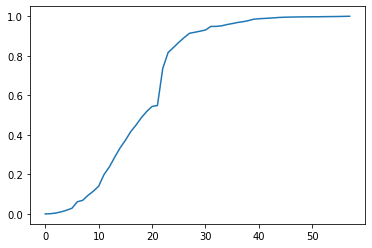

In [14]:
## Standardization
def normalizeData(data):
    scaler = MinMaxScaler().fit(data)
    data = scaler.transform(data)
    return data, scaler
china_total, scaler = normalizeData(china_total)
plt.plot(china_total)

In [15]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return asarray(X), asarray(y)

In [16]:
n_steps = 1
X, y = split_sequence(china_total, n_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [17]:
X.shape

(57, 1, 1)

In [18]:
print('Single input');
print(X[0])
print('Single output');
print(y[0])

Single input
[[0.]]
Single output
[0.00117882]


In [19]:
## Size of X
X.shape

(57, 1, 1)

In [20]:
## Splitting into validation and test sets
number_of_rows = X.shape[0]
n_train = math.ceil(number_of_rows*80/100)
n_test = n_train + math.floor(number_of_rows*10/100)
X_train, y_train, X_val, y_val, X_test, y_test = X[:n_train], y[:n_train], X[n_train:n_test], y[n_train:n_test], X[n_test:], y[n_test:]

In [21]:
tf.keras.backend.clear_session()
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, input_shape=X_train.shape[-2:]),
    tf.keras.layers.Dense(1)
])
opt = optimizers.Nadam(learning_rate=0.0001)
simple_lstm_model.compile(optimizer=opt, loss='mae', metrics=['mae', 'mse', 'msle'])

In [22]:
simple_lstm_model.fit(X_train, y_train, epochs=3000, batch_size=42, verbose=0,
                      validation_data=(X_val, y_val))

In [23]:
simple_lstm_model.evaluate(X_test, y_test, verbose=2)

6/1 - 0s - loss: 0.0064 - mae: 0.0064 - mse: 4.0451e-05 - msle: 1.0094e-05


[0.006358871702104807, 0.0063588717, 4.0450694e-05, 1.0093546e-05]

In [24]:
## This is where we try to predict other country
korea_data = data.loc[data['Country/Region'] == 'Korea, South'];

In [25]:
del korea_data['Lat']
del korea_data['Long']
del korea_data['Province/State']

In [26]:
korea_data = korea_data.melt(id_vars=['Country/Region'], var_name='Date', value_name='Confirmed Cases');

In [27]:
korea_data

,Country/Region,Date,Confirmed Cases
0,"Korea, South",1/22/20,1
1,"Korea, South",1/23/20,1
2,"Korea, South",1/24/20,2
3,"Korea, South",1/25/20,2
4,"Korea, South",1/26/20,3
5,"Korea, South",1/27/20,4
6,"Korea, South",1/28/20,4
7,"Korea, South",1/29/20,4
8,"Korea, South",1/30/20,4
9,"Korea, South",1/31/20,11


In [28]:
korea_data = korea_data.iloc[32:]

In [29]:
korea_data['Date'] = pd.to_datetime(korea_data['Date']);

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
korea_data = korea_data.pivot(index='Date', columns='Country/Region', values='Confirmed Cases');

In [31]:
korea_data

Country/Region,"Korea, South"
Date,
2020-02-23,602
2020-02-24,833
2020-02-25,977
2020-02-26,1261
2020-02-27,1766
2020-02-28,2337
2020-02-29,3150
2020-03-01,3736
2020-03-02,4335


In [32]:
korea_total = pd.DataFrame()
korea_total['Korean Total Confirmed Cases'] = korea_data.sum(axis=1)

In [33]:
korea_total, scaler = normalizeData(korea_total)

In [34]:
X, y = split_sequence(korea_total, n_steps)

In [35]:
X = X.reshape((X.shape[0], X.shape[1], 1))

In [36]:
y_hat = simple_lstm_model.predict(X)
## Gotta somehow convert this to dim of (49, 5, 1) where 5 = number of steps

In [37]:
y = y.reshape(y.shape[0], 1)

In [38]:
simple_lstm_model.evaluate(X, y, verbose=0)

[0.030404090881347656, 0.03040409, 0.0017125766, 0.0008144717]

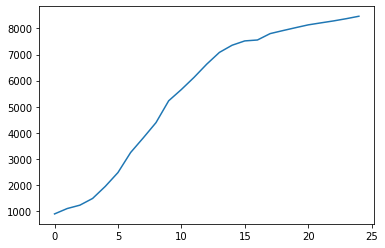

In [39]:
plt.plot(scaler.inverse_transform(y_hat))

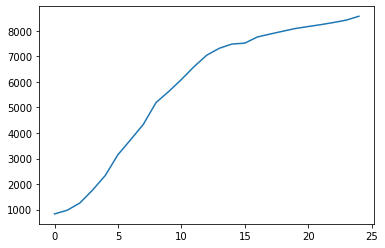

In [40]:
plt.plot(scaler.inverse_transform(y))

In [41]:
scaler.inverse_transform(y_hat)-scaler.inverse_transform(y)

array([[  60.90789795],
       [ 122.98950195],
       [ -31.75219727],
       [-280.08654785],
       [-389.19750977],
       [-671.95117188],
       [-489.60766602],
       [-526.04980469],
       [-795.33789062],
       [-393.91601562],
       [-429.52832031],
       [-468.99316406],
       [-411.21435547],
       [-233.85449219],
       [-122.79882812],
       [   7.61962891],
       [-199.0625    ],
       [ -68.72119141],
       [ -63.54736328],
       [ -59.37841797],
       [ -27.20898438],
       [ -24.36425781],
       [ -33.53125   ],
       [ -41.57226562],
       [ -99.50195312]])

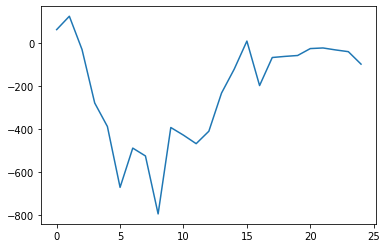

In [42]:
plt.plot(scaler.inverse_transform(y_hat)-scaler.inverse_transform(y))